# Huggett (1993) Model with Aggregate Risk

Heterogeneous-agent economy: individuals have uninsured idiosyncratic labor income risk and save in bonds; bonds are in **zero net supply**. Aggregate TFP $z_t$ is stochastic. The interest rate $r_t$ clears the bond market.

**Individual state:** $(b, y)$ — bond holdings and idiosyncratic income.  
**Aggregate state:** $z$ (and in equilibrium, the cross-sectional distribution).  
**Budget:** $c + b' = (1+r)b + y\,z$, with borrowing constraint $b \geq \underline{b}$.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

## Global parameters (SRL Appendix A.1 — Table 2 & Section 4.1)

- **Preferences:** $E_0 \sum_{t=0}^\infty \beta^t u(c_t)$, isoelastic $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$.
- **Idiosyncratic income** $y_t$: log AR(1), persistence $\rho_y$, innovation volatility $\nu_y$; discretized (e.g. Tauchen) on $n_y$ points.
- **Aggregate income** $z_t$: log AR(1), persistence $\rho_z$, volatility $\nu_z$; discretized (Tauchen) on $n_z$ points.
- **Bonds:** borrowing limit $\underline{b}$, total bond supply $B = 0$ (zero net supply).

In [7]:
# === Calibration (Table 2: Huggett model calibration) ===
# We interpret one period as a year (Section 4.1).

# Preferences
beta = 0.96       # discount factor
sigma = 2.0       # coefficient of relative risk aversion (CRRA)

# Idiosyncratic labor income: log AR(1) with persistence ρy, innovation volatility νy
rho_y = 0.6
nu_y = 0.2

# Aggregate TFP z: log AR(1)
rho_z = 0.9
nu_z = 0.02

# Bonds
B = 0.0          # total bond supply (zero net supply)
b_min = -1.0     # borrowing constraint (b ≥ b_min)

# === Discretization (Table 3: hyperparameters) ===
nb = 200         # number of bond grid points
b_max = 50.0     # upper bound of bond grid
ny = 3           # number of y grid points (idiosyncratic income)
nr = 20          # number of r grid points (market clearing)
r_min = 0.01     # lower bound of r grid [r_L, r_H]
r_max = 0.06     # upper bound of r grid
nz = 30          # number of z grid points (aggregate TFP)

# Truncation and numerics (Appendix A.1)
c_min = 1e-3     # minimum consumption floor (avoids u(c) at 0)
etrunc = 1e-3    # truncation tolerance: β^T < etrunc
T_trunc = int(np.ceil(np.log(etrunc) / np.log(beta)))  # ≈ 170 for beta=0.96

print("Huggett calibration (SRL Appendix A.1):")
print(f"  β={beta}, σ={sigma}, ρy={rho_y}, νy={nu_y}, ρz={rho_z}, νz={nu_z}")
print(f"  B={B}, b_min={b_min}")
print(f"  Grids: nb={nb}, b_max={b_max}, ny={ny}, nr={nr}, r∈[{r_min},{r_max}], nz={nz}")
print(f"  T_trunc={T_trunc}, c_min={c_min}")

Huggett calibration (SRL Appendix A.1):
  β=0.96, σ=2.0, ρy=0.6, νy=0.2, ρz=0.9, νz=0.02
  B=0.0, b_min=-1.0
  Grids: nb=200, b_max=50.0, ny=3, nr=20, r∈[0.01,0.06], nz=30
  T_trunc=170, c_min=0.001


## Grids and utility

- **Bond grid:** equispaced or log-spaced on $[\underline{b},\, b_{\max}]$.
- **Income grids:** Tauchen discretization of the log AR(1) processes for $y$ and $z$ (to be implemented).

In [8]:
# Bond grid: nb points on [b_min, b_max] (Appendix: nb=200, bmax=50)
b_grid = np.linspace(b_min, b_max, nb)

# CRRA utility and derivative (for FOC / Euler)
def u(c, sig=sigma):
    """u(c) = c^(1-σ)/(1-σ); limit for σ=1 is log(c)."""
    c = np.maximum(c, c_min)
    if np.abs(sig - 1.0) < 1e-10:
        return np.log(c)
    return (c ** (1 - sig)) / (1 - sig)

def u_prime(c, sig=sigma):
    """u'(c) = c^(-σ)."""
    c = np.maximum(c, c_min)
    return c ** (-sig)

# Placeholder: y and z grids will be built via Tauchen (same as in SRL)
# y_grid: ny points; z_grid: nz points; transition matrices Ty, Tz
print("b_grid:", b_grid[0], "...", b_grid[-1], "shape", b_grid.shape)

b_grid: -1.0 ... 50.0 shape (200,)


In [9]:
# return the grid and the transition matrix
def tauchen_ar1(rho, sigma_innov, n_states, m=3):
    """
    Tauchen (1986): discretize AR(1) x' = rho*x + eps, eps ~ N(0, sigma_innov^2).
    Returns grid (n_states,) and transition matrix (n_states, n_states).
    m: number of std devs for the state grid (wider grid for persistence).
    """
    sigma_x = sigma_innov / np.sqrt(1 - rho**2)
    x_min = -m * sigma_x
    x_max = m * sigma_x
    x_grid = np.linspace(x_min, x_max, n_states)
    step = (x_max - x_min) / (n_states - 1)
    P = np.zeros((n_states, n_states))
    # the way to discretize is by integrating over the interval length of step and centraled by the value of x_grid
    for i in range(n_states):
        for j in range(n_states):
            if j == 0:
                P[i, j] = norm.cdf((x_grid[j] - rho * x_grid[i] + step / 2) / sigma_innov)
            elif j == n_states - 1:
                P[i, j] = 1 - norm.cdf((x_grid[j] - rho * x_grid[i] - step / 2) / sigma_innov)
            else:
                P[i, j] = (norm.cdf((x_grid[j] - rho * x_grid[i] + step / 2) / sigma_innov) -
                           norm.cdf((x_grid[j] - rho * x_grid[i] - step / 2) / sigma_innov))
    P = P / P.sum(axis=1, keepdims=True)
    return x_grid, P

# Idiosyncratic income y: log y follows AR(1) with rho_y, nu_y (Table 2). Grid in logs then exp.
log_y_grid, Ty = tauchen_ar1(rho_y, nu_y, ny)
y_grid = np.exp(log_y_grid)
# Normalize so E[y]=1 in stationary distribution
invariant_y = np.linalg.matrix_power(Ty.T, 200)[:, 0]
y_grid = y_grid / (y_grid @ invariant_y)

# Aggregate z: log z follows AR(1) with rho_z, nu_z
log_z_grid, Tz = tauchen_ar1(rho_z, nu_z, nz)
z_grid = np.exp(log_z_grid)
invariant_z = np.linalg.matrix_power(Tz.T, 200)[:, 0]
z_grid = z_grid / (z_grid @ invariant_z)

print("y_grid (idiosyncratic, AR(1), ny=%d):" % ny, y_grid)
print("Ty (idiosyncratic transition):\n", Ty)
print("z_grid (aggregate, first 5 ... last 2):", z_grid[:5], "...", z_grid[-2:])

y_grid (idiosyncratic, AR(1), ny=3): [0.4528015  0.95858078 2.02931553]
Ty (idiosyncratic transition):
 [[6.46169767e-01 3.53811697e-01 1.85367378e-05]
 [3.03963618e-02 9.39207276e-01 3.03963618e-02]
 [1.85367378e-05 3.53811697e-01 6.46169767e-01]]
z_grid (aggregate, first 5 ... last 2): [0.87048321 0.87878612 0.88716821 0.89563026 0.90417302] ... [1.13552944 1.14636043]


## Policy Functions

Policy functions for getting consumption strategy π(b, y, r, z). The actual training uses Monte Carlo simulation inside `spg_objective` (see SRL section below).

In [10]:
from scipy.interpolate import interp2d, LinearNDInterpolator
from scipy.optimize import brentq

def policy_from_grid(b, y, r, z, theta_grid, b_grid, y_grid, z_grid, r_grid, ny, c_min_val=1e-3):
    """
    Policy π(b, y, r, z) from trained grid parameters θ.
    Consumption c = π(b, y, r, z) is obtained by interpolation from theta_grid.
    theta_grid shape: (J, nz, nr) where J = nb * ny
    Returns (c, b_next) where b_next = (1+r)*b + y*z - c, clamped to [b_min, b_max].
    """
    # Convert to numpy if needed
    if hasattr(theta_grid, 'detach'):
        theta_grid = theta_grid.detach().cpu().numpy()
    if hasattr(b_grid, 'detach'):
        b_grid = b_grid.detach().cpu().numpy()
    if hasattr(y_grid, 'detach'):
        y_grid = y_grid.detach().cpu().numpy()
    if hasattr(z_grid, 'detach'):
        z_grid = z_grid.detach().cpu().numpy()
    if hasattr(r_grid, 'detach'):
        r_grid = r_grid.detach().cpu().numpy()
    
    # Find grid indices
    ib = np.clip(np.searchsorted(b_grid, b), 0, len(b_grid) - 1)
    iy = np.clip(np.searchsorted(y_grid, y), 0, len(y_grid) - 1)
    iz = np.clip(np.searchsorted(z_grid, z), 0, len(z_grid) - 1)
    ir = np.clip(np.searchsorted(r_grid, r), 0, len(r_grid) - 1)
    
    # Handle vectorized inputs
    if np.isscalar(b):
        ib = [ib]
        iy = [iy]
        iz = [iz]
        ir = [ir]
        b = np.array([b])
        y = np.array([y])
        r = np.array([r])
        z = np.array([z])
    
    # Get consumption from grid: j = ib * ny + iy
    # theta_grid[j, iz, ir] directly stores consumption c = π(b, y, r, z)
    c = np.zeros(len(b))
    for i in range(len(b)):
        j = ib[i] * ny + iy[i]
        # Get consumption from trained grid
        c[i] = np.maximum(theta_grid[j, iz[i], ir[i]], c_min_val)
    
    # Compute b_next from budget constraint: b' = (1+r)*b + y*z - c
    c_total = (1 + r) * b + y * z  # Total resources available
    b_next = c_total - c  # Remaining after consumption
    # Clamp b_next to [b_min, b_max] and adjust c if needed to satisfy budget
    b_next_clipped = np.clip(b_next, b_min, b_max)
    # If b_next was clipped, adjust consumption to satisfy budget: c = (1+r)*b + y*z - b'
    c = np.maximum(c_total - b_next_clipped, c_min_val)
    b_next = b_next_clipped
    
    if len(c) == 1:
        return c[0], b_next[0]
    return c, b_next

def policy_placeholder(b, y, r, z, save_frac=0.2):
    """
    Placeholder policy π(b, y, r, z): returns (c, b_next).
    This is a simple rule-based policy for testing. 
    For actual training, use policy_from_grid with trained theta_grid.
    """
    c = (1 + r) * b + y * z
    b_next = np.clip(save_frac * c, b_min, b_max)
    c = np.maximum(c - b_next, c_min)
    return c, b_next

def draw_next_state(y_idx, z_idx, Ty, Tz):
    """Draw (y_{t+1} index, z_{t+1} index) from Ty[y_idx,:] and Tz[z_idx,:]."""
    y_next = np.searchsorted(np.cumsum(Ty[y_idx, :]), np.random.rand())
    z_next = np.searchsorted(np.cumsum(Tz[z_idx, :]), np.random.rand())
    return y_next, z_next

In [11]:
def aggregate_saving(b_vec, y_vec, r, z, policy_fn):
    """Total (average) saving b' given current (b_vec, y_vec), price r, aggregate z, and policy π."""
    c, b_next = policy_fn(b_vec, y_vec, r, z)
    return np.mean(b_next)

def ge_price(b_vec, y_vec, z, policy_fn, r_lo=None, r_hi=None):
    """
    P*(g_t, z_t): find r_t such that aggregate saving = B (market clearing).
    In Huggett, B=0 so we solve mean(b') = 0.
    """
    r_lo = r_min if r_lo is None else r_lo
    r_hi = r_max if r_hi is None else r_hi
    def excess_saving(r):
        return aggregate_saving(b_vec, y_vec, r, z, policy_fn) - B
    if excess_saving(r_lo) * excess_saving(r_hi) > 0:
        return (r_lo + r_hi) / 2.0  # fallback if no crossing
    return brentq(excess_saving, r_lo, r_hi)

In [12]:
def simulate_huggett(
    T,
    N_agents,
    policy_fn,
    y_grid, z_grid, Ty, Tz,
    z0_idx=None,
    b0=None,
    y0_idx=None,
):
    """
    Simulate the Huggett economy for T periods, N_agents (Figure 2). GE only: r_t clears bond market each period.

    Returns:
        paths: dict with 'b', 'y_idx', 'y', 'z_idx', 'z', 'r', 'c'
        v_hat: scalar, sum_t β^t * mean(u(c_t))
    """
    if z0_idx is None:
        z0_idx = np.random.randint(0, len(z_grid))
    if y0_idx is None:
        y0_idx = np.random.randint(0, len(y_grid), size=N_agents)
    if b0 is None:
        b0 = np.zeros(N_agents)

    b = b0.copy()
    y_idx = y0_idx.copy()
    z_idx = np.array([z0_idx])

    paths = {
        'b': np.zeros((T + 1, N_agents)),
        'y_idx': np.zeros((T + 1, N_agents), dtype=int),
        'y': np.zeros((T + 1, N_agents)),
        'z_idx': np.zeros(T + 1, dtype=int),
        'z': np.zeros(T + 1),
        'r': np.zeros(T + 1),
        'c': np.zeros((T + 1, N_agents)),
    }
    paths['b'][0] = b
    paths['y_idx'][0] = y_idx
    paths['y'][0] = y_grid[y_idx]
    paths['z_idx'][0] = z_idx[0]
    paths['z'][0] = z_grid[z_idx[0]]
    paths['r'][0] = np.nan
    paths['c'][0] = np.nan

    for t in range(T):
        z_val = z_grid[z_idx[0]]
        y_val = y_grid[y_idx]
        r_t = ge_price(b, y_val, z_val, policy_fn)
        paths['r'][t] = r_t

        c_t, b_next = policy_fn(b, y_val, r_t, z_val)
        paths['c'][t] = c_t

        b = b_next
        paths['b'][t + 1] = b
        y_idx_next = np.array([draw_next_state(y_idx[i], z_idx[0], Ty, Tz)[0] for i in range(N_agents)])
        z_idx_next = np.searchsorted(np.cumsum(Tz[z_idx[0], :]), np.random.rand())
        y_idx = y_idx_next
        z_idx[0] = z_idx_next

        paths['y_idx'][t + 1] = y_idx
        paths['y'][t + 1] = y_grid[y_idx]
        paths['z_idx'][t + 1] = z_idx[0]
        paths['z'][t + 1] = z_grid[z_idx[0]]
    paths['r'][T] = paths['r'][T - 1]
    paths['c'][T] = policy_placeholder(paths['b'][T], paths['y'][T], paths['r'][T], paths['z'][T])[0]

    # v̂_π: discounted average utility (over agents and time)
    c_path = paths['c'][:T]
    v_hat = np.sum([(beta ** t) * np.mean(u(c_path[t])) for t in range(T)])

    return paths, v_hat

In [ ]:
# Note: For SRL training, Monte Carlo simulation is done inside spg_objective().
# The simulate_huggett() function above is kept for reference/testing purposes only.
# SRL training uses Monte Carlo trajectories directly in the objective function.

GE simulation done. v̂_π (discounted avg utility): -27.557853745915764
Mean r (GE): 0.034999999999999996
Mean aggregate b (should ≈ 0): [0.         0.20878769 0.24357584 0.24516388 0.24198611] ...


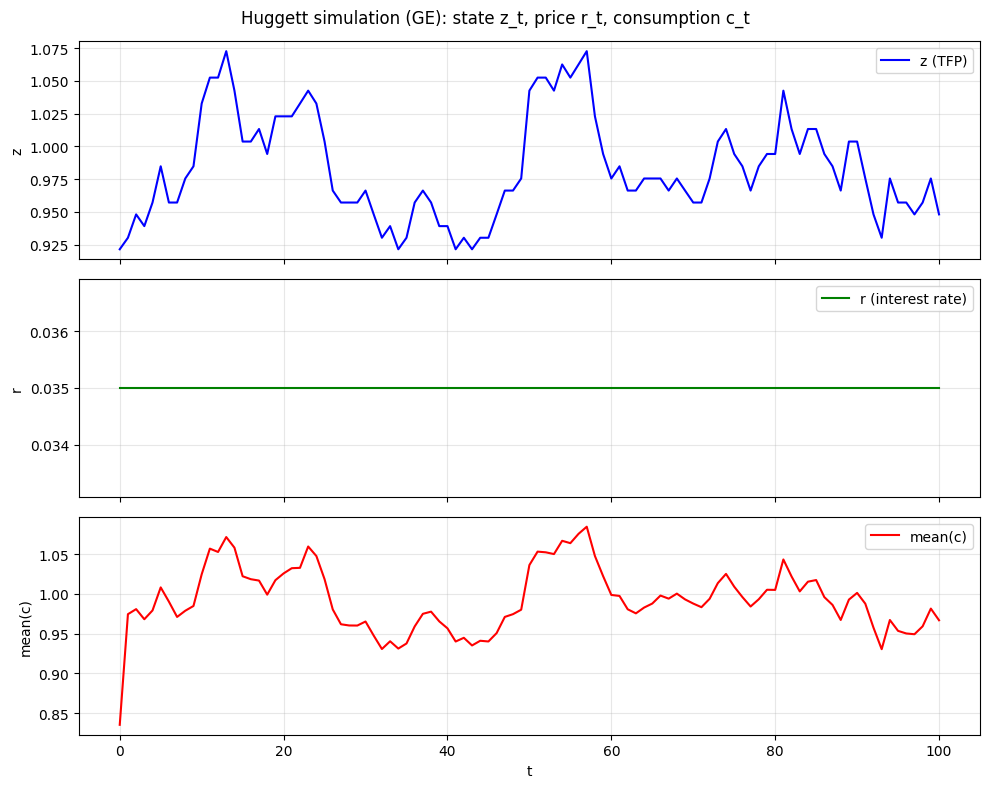

In [ ]:
# Visualization code for simulation results (optional, for testing purposes)
# For SRL, visualization can be done after training using the trained policy

## SRL / SPG: Gradient-stop on macro, gradient descent on policy (SRL Section 3.2–3.3)

**Objective:** Maximize expected lifetime utility

$$L(\theta) = d_0^T \hat{v}_\pi$$

where $\hat{v}_\pi$ is the sample average over $N$ simulated trajectories (Monte Carlo).

**Macro (no gradient):** The price $p_t = P^*(g_t, z_t)$ is given by market clearing. We apply **stop-gradient** to $p_t$, so $\partial p_t / \partial \theta = 0$ — agents take prices as given.

**Micro (differentiate):** The policy $\pi(\cdot; \theta)$ and the transition matrix $A_\pi(z, p)$ depend on $\theta$; we backpropagate through them and through $u(c)$.

**Update:** Stochastic gradient ascent

$$\theta_{k+1} = \theta_k + \eta_k \nabla_\theta L(\theta_k)$$

In [15]:
# SRL/SPG: PyTorch for autograd; gradient-stop on prices
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

# Coarser grid for SPG (Appendix Table 3: nb=200, but we use smaller for speed)
nb_spg = 50
nr_spg = 10
nz_spg = 10
# ny, b_min, b_max, etc. from above; use same y_grid, z_grid, Ty, Tz (or subsample)
J = nb_spg * ny  # individual states: (b_idx, y_idx) -> j = b_idx*ny + y_idx

# Build SPG grids (can subsample from main grids)
b_grid_spg = torch.tensor(np.linspace(b_min, b_max, nb_spg), dtype=dtype, device=device)
# Subsample z and r for SPG
iz_spg = np.linspace(0, nz-1, nz_spg, dtype=int)
ir_spg = np.linspace(0, nr-1, nr_spg, dtype=int) if nr <= 20 else np.arange(nr_spg)
z_grid_t = torch.tensor(z_grid[iz_spg], dtype=dtype, device=device)
r_grid_t = torch.tensor(np.linspace(r_min, r_max, nr_spg), dtype=dtype, device=device)
y_grid_t = torch.tensor(y_grid, dtype=dtype, device=device)
Ty_t = torch.tensor(Ty, dtype=dtype, device=device)
Tz_sub = Tz[np.ix_(iz_spg, iz_spg)] if len(iz_spg) <= len(z_grid) else Tz
Tz_sub = Tz_sub / Tz_sub.sum(axis=1, keepdims=True)
Tz_t = torch.tensor(Tz_sub, dtype=dtype, device=device)
nz_spg = Tz_t.shape[0]

# Policy parameter θ: consumption c on (J, nz_spg, nr_spg) grid. Initialize near steady-state consumption.
# c(s,z,p) = θ[j, iz, ir]. Budget: b' = (1+r)*b + y*z - c, clamped.
def theta_to_consumption_grid(theta, b_grid_t, y_grid_t, z_grid_t, r_grid_t, c_min_val=1e-3):
    """θ shape (J, nz, nr) -> c same shape, ensured >= c_min."""
    return torch.nn.functional.softplus(theta) + c_min_val

# Initial θ: imply consumption from a constant saving rule (e.g. c = (1-ss)*c)
def init_theta(b_grid_t, y_grid_t, z_grid_t, r_grid_t, save_frac=0.2, c_min_val=1e-3):
    J = len(b_grid_t) * len(y_grid_t)
    nz_t, nr_t = len(z_grid_t), len(r_grid_t)
    c_grid = torch.zeros(J, nz_t, nr_t, dtype=dtype, device=device)
    for ib in range(len(b_grid_t)):
        for iy in range(len(y_grid_t)):
            j = ib * len(y_grid_t) + iy
            b = b_grid_t[ib].item()
            y = y_grid_t[iy].item()
            for iz in range(nz_t):
                z = z_grid_t[iz].item()
                for ir in range(nr_t):
                    r = r_grid_t[ir].item()
                    c = (1 + r) * b + y * z
                    c = max((1 - save_frac) * c, c_min_val)
                    c_grid[j, iz, ir] = c
    # inverse of softplus: theta such that softplus(theta)+c_min = c_grid
    x = c_grid - c_min_val
    theta_init = torch.log(torch.exp(x) - 1 + 1e-8)
    return theta_init

In [16]:
# Build transition matrix A_π(z, p) from θ. A_π is J×J; differentiable in θ. Use detached p for macro.
def build_A_pi(theta, iz, ir, b_grid_t, y_grid_t, z_grid_t, r_grid_t, Ty_t, nb_spg, ny, sigma_b=0.1):
    """
    A_π[j', j] = P(s'=j' | s=j) under policy θ at (z_grid[iz], r_grid[ir]).
    b' = (1+r)*b + y*z - c; map b' to b-grid via soft weights for differentiability.
    """
    J = nb_spg * ny
    z_val = z_grid_t[iz]
    r_val = r_grid_t[ir]
    c = theta_to_consumption_grid(theta, b_grid_t, y_grid_t, z_grid_t, r_grid_t)
    c_val = c[:, iz, ir]  # (J,)
    b_next = (1 + r_val) * b_grid_t.repeat_interleave(ny) + y_grid_t.repeat(nb_spg) * z_val - c_val
    b_next = torch.clamp(b_next, b_min, b_max)
    # Soft weights: weight_ib = exp(-(b'-b_grid[ib])^2/(2*sigma^2)), normalized
    dist = b_next.unsqueeze(1) - b_grid_t.unsqueeze(0)  # (J, nb)
    w_b = torch.exp(-dist.pow(2) / (2 * sigma_b**2))
    w_b = w_b / (w_b.sum(dim=1, keepdim=True) + 1e-8)
    # A_π: from j=(ib,iy) to j'=(ib',iy'): weight_b(ib') * Ty[iy, iy']
    A = torch.zeros(J, J, dtype=dtype, device=device)
    for j in range(J):
        ib, iy = j // ny, j % ny
        for ibp in range(nb_spg):
            for iyp in range(ny):
                jp = ibp * ny + iyp
                A[jp, j] = w_b[j, ibp] * Ty_t[iy, iyp]
    return A

def aggregate_saving_grid(theta, d, iz, ir, b_grid_t, y_grid_t, z_grid_t, r_grid_t, ny):
    """Aggregate saving d^T b'(θ,z,r); used for market clearing."""
    J = d.shape[0]
    z_val = z_grid_t[iz]
    r_val = r_grid_t[ir]
    c = theta_to_consumption_grid(theta, b_grid_t, y_grid_t, z_grid_t, r_grid_t)[:, iz, ir]
    b_next = (1 + r_val) * b_grid_t.repeat_interleave(ny) + y_grid_t.repeat(nb_spg) * z_val - c
    b_next = torch.clamp(b_next, b_min, b_max)
    return (d * b_next).sum()

def P_star_detach(theta, d, iz, b_grid_t, y_grid_t, z_grid_t, r_grid_t, ny, B=0.0):
    """Find ir that minimizes |aggregate_saving - B|; return r_grid_t[ir].detach() (gradient-stop)."""
    best_ir, best_err = 0, float('inf')
    for ir in range(len(r_grid_t)):
        S = aggregate_saving_grid(theta, d, iz, ir, b_grid_t, y_grid_t, z_grid_t, r_grid_t, ny)
        err = (S - B).abs().item()
        if err < best_err:
            best_err, best_ir = err, ir
    return r_grid_t[best_ir].detach()

In [17]:
# Map scalar r (e.g. detached) to grid index for policy lookup
def r_to_ir(r_val, r_grid_t):
    r_np = r_grid_t.detach().cpu().numpy()
    return int(np.clip(np.searchsorted(r_np, r_val.item() if torch.is_tensor(r_val) else r_val), 0, len(r_np)-1))

# Utility on grid (vector over J)
def u_torch(c_vec, sig=sigma):
    c_vec = torch.clamp(c_vec, min=c_min)
    if abs(sig - 1.0) < 1e-8:
        return torch.log(c_vec)
    return (c_vec ** (1 - sig)) / (1 - sig)

In [18]:
# SPG: Simulate N paths with gradient-stop on p_t; maximize L(θ) = (1/N) Σ_n Σ_t β^t d_t^T u(c_t)
def spg_objective(theta, N_traj, T_horizon, b_grid_t, y_grid_t, z_grid_t, r_grid_t, Ty_t, Tz_t,
                  nb_spg, ny, nz_spg, nr_spg, beta_t, d0=None):
    """
    L(θ) = (1/N) Σ_n Σ_t β^t (d_π,t)^T u(c_t).
    p_t = P*(d_t, z_t) is computed and then .detach() so ∇_θ does not flow through macro.
    """
    J = nb_spg * ny
    if d0 is None:
        d0 = torch.ones(J, device=device, dtype=dtype) / J
    L_list = []
    for n in range(N_traj):
        iz = np.random.randint(0, nz_spg)
        d = d0.clone()
        L_n = torch.tensor(0.0, device=device, dtype=dtype)
        for t in range(T_horizon):
            # Price with gradient-stop (SRL: agents take prices as given)
            r_t = P_star_detach(theta, d, iz, b_grid_t, y_grid_t, z_grid_t, r_grid_t, ny)
            ir = r_to_ir(r_t, r_grid_t)
            c = theta_to_consumption_grid(theta, b_grid_t, y_grid_t, z_grid_t, r_grid_t)
            c_t = c[:, iz, ir]
            L_n = L_n + (beta_t ** t) * (d @ u_torch(c_t))
            A = build_A_pi(theta, iz, ir, b_grid_t, y_grid_t, z_grid_t, r_grid_t, Ty_t, nb_spg, ny)
            d = A.T @ d
            cum = np.cumsum(Tz_t[iz, :].detach().cpu().numpy())
            iz = min(np.searchsorted(cum, np.random.rand()), nz_spg - 1)
        L_list.append(L_n)
    return torch.stack(L_list).mean()

## Using Trained Policy

After training, convert theta to consumption grid and use `policy_from_grid` to get consumption strategy π(b, y, r, z) from the trained grid.

In [19]:
# After training, convert theta to consumption grid
theta_trained = theta.detach()  # Use trained theta (no gradient needed for simulation)
c_grid_trained = theta_to_consumption_grid(theta_trained, b_grid_spg, y_grid_t, z_grid_t, r_grid_t)
c_grid_np = c_grid_trained.cpu().numpy()  # Convert to numpy for policy_from_grid

# Create policy function using trained grid
def policy_trained(b, y, r, z):
    """Policy function using trained theta grid"""
    return policy_from_grid(
        b, y, r, z, 
        c_grid_np,  # Consumption grid from trained theta
        b_grid_spg.cpu().numpy(),
        y_grid_t.cpu().numpy(),
        z_grid_t.cpu().numpy(),
        r_grid_t.cpu().numpy(),
        ny
    )

# Example: test the trained policy
print("Testing trained policy:")
b_test = np.array([0.5, 1.0, 2.0])
y_test = y_grid[1]  # Use middle income level
r_test = (r_min + r_max) / 2.0  # mid-grid r for testing
z_test = z_grid[len(z_grid)//2]  # Use middle z value

c_test, b_next_test = policy_trained(b_test, y_test, r_test, z_test)
print(f"  b = {b_test}, y = {y_test:.3f}, r = {r_test:.3f}, z = {z_test:.3f}")
print(f"  c = {c_test}, b_next = {b_next_test}")
print(f"  Budget check: (1+r)*b + y*z = {(1+r_test)*b_test + y_test*z_test}")
print(f"  Budget satisfied: c + b_next = {c_test + b_next_test}")

NameError: name 'theta' is not defined

In [ ]:
# Initialize θ and run SPG (gradient ascent on L(θ))
nr_spg = len(r_grid_t)
nz_spg = len(z_grid_t)
theta = init_theta(b_grid_spg, y_grid_t, z_grid_t, r_grid_t)
theta = theta.requires_grad_(True)
optimizer = torch.optim.Adam([theta], lr=1e-3)
N_traj = 32
T_horizon = 30
n_epochs = 100
loss_hist = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    L = spg_objective(theta, N_traj, T_horizon, b_grid_spg, y_grid_t, z_grid_t, r_grid_t, Ty_t, Tz_t,
                      nb_spg, ny, nz_spg, nr_spg, beta)
    loss_hist.append(L.item())
    (-L).backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, L(θ) = {L.item():.6f}")